In [1]:
# approach to cluster data by mobility pattern

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
from datetime import time

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

## Load Data

In [3]:
df = pd.read_csv(r'..\data\processed\trips_custom_variables.csv', dtype = {'VORIHORAINI':str, 'VDESHORAFIN':str}, parse_dates = ['start_time','end_time'])
# df_trips = pd.read_csv(r'..\data\processed\trips_georeferenced.csv', dtype = {'VORIHORAINI':str, 'VDESHORAFIN':str})

In [4]:
df_spatial_category = pd.read_csv(r'..\data\interim\match_zt1259_to_category.csv')

In [5]:
codes = pd.read_csv(r'..\data\processed\codes_translated.csv', dtype = {'CODE': float})

### Clustering


**Clustering variables**
- distance
- tripcount
- legs count per trip
- speed
- daytime (HVZ, NVZ, SVZ: https://de.wikipedia.org/wiki/Verkehrszeiten)
- mode

In [6]:
# TODO: use weights not acutal numbers

### preprocessing

In [7]:
df = df.join(df_spatial_category.set_index("ZT1259"), how = 'left', on = "ZT1259")
df = df.rename({"category": "home_zone"}, axis = 1)
df = df.join(df_spatial_category.set_index("ZT1259"), how = 'left', on = "VORIZT1259")
df = df.rename({"category": "start_zone"}, axis = 1)
df = df.join(df_spatial_category.set_index("ZT1259"), how = 'left', on = "VDESZT1259")
df = df.rename({"category": "dest_zone"}, axis = 1)

# one hot encoding daytime
one_hot = pd.get_dummies(df.daytime)
# Drop column B as it is now encoded
# Join the encoded df
df = df.join(one_hot)

# one hot encoding mode
one_hot = pd.get_dummies(df.mode_simple)
# Drop column B as it is now encoded
# Join the encoded df
df = df.join(one_hot)

cluster_var = df.groupby(['ID_HOGAR','ID_IND', 'C2SEXO', 'sex','home_zone']).agg({'ID_VIAJE' : 'count', #tripcount
 'ELE_G_POND': 'first', # TODO: check proper weighting
 'DISTANCIA_VIAJE' : 'mean', # average distance per trip
 'N_ETAPAS_POR_VIAJE' : 'mean', #average legs per trip
 'speed' : 'median',
 'public transport' : 'mean',
 'car' : 'mean',
 'rush hour (HVZ)' : 'mean',
 'off-peak hour (NVZ)' : 'mean',
'low traffic time (SVZ)': 'mean'})

cluster_var.rename(columns = {
    'ID_VIAJE':'tripcount',
    'DISTANCIA_VIAJE':'average_dist',
    'N_ETAPAS_POR_VIAJE':'average_legs'
}, inplace = True)

cluster_var.fillna(-1, inplace = True)

## set variables used for clustering

In [8]:
df = cluster_var[["rush hour (HVZ)", "public transport"]]

## clustering

In [9]:
kmeans = KMeans(n_clusters=4).fit(df)
centroids = kmeans.cluster_centers_
print(centroids)

[[0.06036483 0.0112172 ]
 [0.62496468 0.8742369 ]
 [0.64775198 0.01369867]
 [0.08049809 0.86109068]]


In [10]:
mask = kmeans.predict(df)

### clustering results

In [11]:
# how many cases are in each cluster?
pd.Series(mask).value_counts()

0    33308
2    28594
1    13433
3     9729
dtype: int64

In [12]:
cluster_var["cluster"] = mask

In [13]:
# how is the sex ratio in each cluster?
weighted = cluster_var.groupby(["cluster", "sex"]).agg({'ELE_G_POND': 'sum'})
cluster_sums = weighted.reset_index().groupby("cluster").agg({'ELE_G_POND':'sum'}).rename({'ELE_G_POND':'summed'}, axis = 1)
weighted= weighted.join(cluster_sums)
weighted["perc"] = weighted.ELE_G_POND / weighted.summed
weighted.drop(["ELE_G_POND", "summed"], axis  = 1)

perc
cluster sex            
0       Man    0.460419
        Woman  0.539581
1       Man    0.442126
        Woman  0.557874
2       Man    0.535856
        Woman  0.464144
3       Man    0.411903
        Woman  0.588097

In [14]:
# what are the centroids for each cluster and clustering variable?
pd.DataFrame(centroids, columns = df.columns)

,rush hour (HVZ),public transport
0,0.060365,0.011217
1,0.624965,0.874237
2,0.647752,0.013699
3,0.080498,0.861091


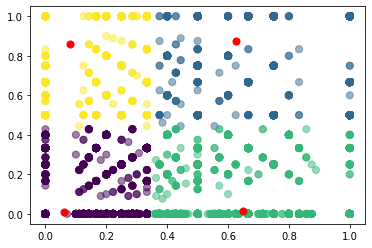

In [15]:
# plot all clusters and centroids
plt.scatter(df['rush hour (HVZ)'], df['public transport'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

In [16]:
# TODO: other clustering than k-means?
#from sklearn.cluster import AgglomerativeClustering
#t = df.reset_index()[["tripcount", "rush hour (HVZ)"]]
#clustering = AgglomerativeClustering().fit(t[1:0000])
#clustering
#clustering.labels_